In [1]:
%env CUDA_VISIBLE_DEVICES=2
import os
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
from k_space_reconstruction.nets.unet import UnetSMPModule, Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
import albumentations
from tqdm import tqdm
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torchvision.transforms as transforms

from os.path import isdir, join
from typing import Callable, Dict, List, Any

fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(4 * nc, 4), dpi=100, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))

env: CUDA_VISIBLE_DEVICES=2


In [2]:
def ce_loss(true, logits, weights, ignore=255):
    torch.nn.CrossEntropyLoss
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss


def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


class ACDCDataset3D(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path: str):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.slices = []
        for k in self.hf.keys():
#             for kk in self.hf[k].keys():
            self.slices.append(k)

    def __len__(self) -> int:
        return len(self.slices)

    def __getitem__(self, item: int):
        k = self.slices[item]
        
        img0 = self.hf[k]['0'][0]
        mask0 = self.hf[k]['0'][1]
        c = self.hf[k]['0'].attrs['class']
        img0 = torch.tensor(img0).float()
        mask0 = torch.tensor(mask0)
        mean0 = img0.mean(dim=(1,2)).unsqueeze(1).unsqueeze(1)
        std0 = img0.std(dim=(1,2)).unsqueeze(1).unsqueeze(1)
        img0 = (img0 - mean0) / (std0 + 1e-11)
        
        img1 = self.hf[k]['1'][0]
        mask1 = self.hf[k]['1'][1]
        c = self.hf[k]['1'].attrs['class']
        img1 = torch.tensor(img1).float()
        mask1 = torch.tensor(mask1)
        mean1 = img1.mean(dim=(1,2)).unsqueeze(1).unsqueeze(1)
        std1 = img1.std(dim=(1,2)).unsqueeze(1).unsqueeze(1)
        img1 = (img1 - mean1) / (std1 + 1e-11)
        return c, k, mask0.unsqueeze(1), img0.unsqueeze(1), mean0, std0, mask1.unsqueeze(1), img1.unsqueeze(1), mean1, std1


class ACDCDataset2D(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path: str, aug=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug = aug
        self.slices = []
        for k in self.hf.keys():
            for kk in self.hf[k].keys():
                for i in range(self.hf[k][kk].shape[1]):
                    self.slices.append((i, k, kk))

    def __len__(self) -> int:
        return len(self.slices)

    def __getitem__(self, item: int):
        idx, k, kk = self.slices[item]
        img = self.hf[k][kk][0,idx][np.newaxis,:,:]
        mask = self.hf[k][kk][1,idx][np.newaxis,:,:]
        if self.aug:
            aug = self.aug(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        c = self.hf[k][kk].attrs['class']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask)
        mean = img.mean()
        std = img.std()
        img = (img - mean) / (std + 1e-11)
        return c, mask, img, mean.unsqueeze(0).unsqueeze(0).unsqueeze(0), std.unsqueeze(0).unsqueeze(0).unsqueeze(0)

In [3]:
import torchio
import volumentations

augmentation_aug = volumentations.Compose([
    volumentations.Flip(1),
    volumentations.Flip(2),
    volumentations.RandomRotate90((1,2)),
])

augmentation_tio = torchio.transforms.Compose([
    torchio.transforms.OneOf([
#         torchio.transforms.RandomGhosting(),
#         torchio.transforms.RandomBiasField(),
        torchio.transforms.RandomNoise(),
    ]),
])
train_dataset = ACDCDataset2D('/home/a_razumov/small_datasets/acdc_seg_h5/train_3d.h5', None)
val_dataset = ACDCDataset2D('/home/a_razumov/small_datasets/acdc_seg_h5/val_3d.h5', None)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [4]:
len(train_dataset), len(val_dataset)

(1328, 574)

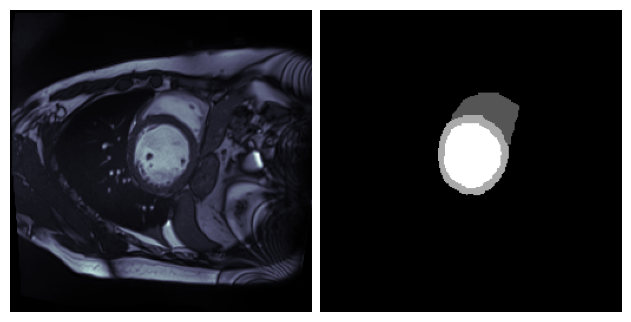

In [5]:
c, mask, img, mean, std = train_dataset[3]
fig, ax = fig_bezzeless(2,1)
ax[0].imshow(img.numpy()[0], cmap=plt.cm.bone)
ax[1].imshow(mask.numpy()[0], alpha=1, cmap=plt.cm.binary_r)
plt.show()

## Segmentation

### Unet attention

In [6]:
from network import AttU_Net

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = AttU_Net(1, 3+1, 32).to(device)
optimizer = torch.optim.AdamW(model.parameters())
criterion = lambda p,t : dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25
metric = lambda p,t : 1 - dice_loss(t, p)

In [8]:
if not os.path.exists('acdc_unet_checkpoints'):
    os.makedirs('acdc_unet_checkpoints')

train_losses = np.ones(50)
val_losses = np.ones(50)
checkpoints = []
for epoch in range(50):
    train_loss = 0.
    val_loss = 0.
    model.train()
    pbar = tqdm(train_generator, total=len(train_generator))
    for _, targets, images, _, _ in pbar:
        images = augmentation_tio(images).to(device)
        targets = targets.to(device).long()
        optimizer.zero_grad()
        # backpropagate
        pred = model(images)
        loss = criterion(pred, targets)
        loss.backward()
        pbar.set_description('loss: %.5f, dice: %.3f' % (loss.item(), metric(pred, targets).item()))
        optimizer.step()
        train_loss += loss.item() / len(train_generator)
    model.eval()
    for _, targets, images, _, _ in tqdm(val_generator, total=len(val_generator)):
        images = images.to(device)
        targets = targets.to(device).long()
        with torch.no_grad():
            pred = model(images)
        loss = criterion(pred, targets)
        val_loss += loss.item() / len(val_generator)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    checkpoint_path = join('acdc_unet_checkpoints', 'epoch%d.pth' % epoch)
    torch.save(model.state_dict(), checkpoint_path)
    checkpoints.append(checkpoint_path)
    print('epoch: %d train loss: %.3f val loss: %.3f time: %s' % (epoch, train_loss, val_loss, str(datetime.datetime.now())))
best_checkpoint = checkpoints[np.argmin(val_losses)]
model.load_state_dict(torch.load(best_checkpoint))

  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 0 train loss: 0.878 val loss: 0.800 time: 2021-04-01 12:23:32.633161


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 1 train loss: 0.725 val loss: 0.693 time: 2021-04-01 12:24:03.118203


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 2 train loss: 0.599 val loss: 0.655 time: 2021-04-01 12:24:33.474940


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 3 train loss: 0.411 val loss: 0.383 time: 2021-04-01 12:25:04.145015


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 4 train loss: 0.239 val loss: 0.222 time: 2021-04-01 12:25:34.923025


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 5 train loss: 0.156 val loss: 0.164 time: 2021-04-01 12:26:05.500047


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 6 train loss: 0.123 val loss: 0.139 time: 2021-04-01 12:26:36.161378


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 7 train loss: 0.109 val loss: 0.136 time: 2021-04-01 12:27:06.846434


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 8 train loss: 0.094 val loss: 0.170 time: 2021-04-01 12:27:37.179628


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 9 train loss: 0.089 val loss: 0.094 time: 2021-04-01 12:28:07.505846


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 10 train loss: 0.077 val loss: 0.085 time: 2021-04-01 12:28:38.143492


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 11 train loss: 0.072 val loss: 0.083 time: 2021-04-01 12:29:08.898445


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 12 train loss: 0.076 val loss: 0.085 time: 2021-04-01 12:29:39.450758


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 13 train loss: 0.071 val loss: 0.092 time: 2021-04-01 12:30:09.915143


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 14 train loss: 0.065 val loss: 0.074 time: 2021-04-01 12:30:40.594976


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 15 train loss: 0.063 val loss: 0.073 time: 2021-04-01 12:31:11.293681


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 16 train loss: 0.058 val loss: 0.070 time: 2021-04-01 12:31:41.903957


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 17 train loss: 0.060 val loss: 0.066 time: 2021-04-01 12:32:12.460174


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 18 train loss: 0.061 val loss: 0.068 time: 2021-04-01 12:32:42.848012


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 19 train loss: 0.058 val loss: 0.064 time: 2021-04-01 12:33:13.556744


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 20 train loss: 0.057 val loss: 0.067 time: 2021-04-01 12:33:44.123436


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 21 train loss: 0.054 val loss: 0.064 time: 2021-04-01 12:34:14.782667


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 22 train loss: 0.051 val loss: 0.069 time: 2021-04-01 12:34:45.410174


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 23 train loss: 0.054 val loss: 0.064 time: 2021-04-01 12:35:15.790714


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 24 train loss: 0.050 val loss: 0.071 time: 2021-04-01 12:35:46.668733


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 25 train loss: 0.048 val loss: 0.059 time: 2021-04-01 12:36:17.284648


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 26 train loss: 0.054 val loss: 0.063 time: 2021-04-01 12:36:47.950569


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 27 train loss: 0.049 val loss: 0.059 time: 2021-04-01 12:37:18.734405


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 28 train loss: 0.048 val loss: 0.064 time: 2021-04-01 12:37:49.540234


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 29 train loss: 0.047 val loss: 0.058 time: 2021-04-01 12:38:20.009618


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 30 train loss: 0.044 val loss: 0.054 time: 2021-04-01 12:38:50.589433


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 31 train loss: 0.046 val loss: 0.059 time: 2021-04-01 12:39:21.076143


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 32 train loss: 0.047 val loss: 0.061 time: 2021-04-01 12:39:51.450201


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 33 train loss: 0.046 val loss: 0.071 time: 2021-04-01 12:40:22.351976


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 34 train loss: 0.046 val loss: 0.059 time: 2021-04-01 12:40:53.288115


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 35 train loss: 0.043 val loss: 0.058 time: 2021-04-01 12:41:23.868093


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 36 train loss: 0.053 val loss: 0.063 time: 2021-04-01 12:41:54.518801


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 37 train loss: 0.047 val loss: 0.065 time: 2021-04-01 12:42:25.181528


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 38 train loss: 0.043 val loss: 0.055 time: 2021-04-01 12:42:55.921592


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 39 train loss: 0.041 val loss: 0.053 time: 2021-04-01 12:43:26.563288


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 40 train loss: 0.041 val loss: 0.055 time: 2021-04-01 12:43:56.905234


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 41 train loss: 0.042 val loss: 0.058 time: 2021-04-01 12:44:27.689500


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 42 train loss: 0.040 val loss: 0.052 time: 2021-04-01 12:44:58.491778


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 43 train loss: 0.040 val loss: 0.058 time: 2021-04-01 12:45:28.921352


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 44 train loss: 0.040 val loss: 0.054 time: 2021-04-01 12:45:59.495821


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 45 train loss: 0.040 val loss: 0.055 time: 2021-04-01 12:46:30.185503


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 46 train loss: 0.040 val loss: 0.054 time: 2021-04-01 12:47:00.945080


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 47 train loss: 0.040 val loss: 0.057 time: 2021-04-01 12:47:31.553042


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 48 train loss: 0.046 val loss: 0.064 time: 2021-04-01 12:48:01.935371


100%|██████████| 18/18 [00:03<00:00,  4.50it/s]

epoch: 49 train loss: 0.042 val loss: 0.058 time: 2021-04-01 12:48:32.497781


<All keys matched successfully>

In [9]:
torch.save(model.state_dict(), 'unet-attention-32.pt')

0.8234368562698364


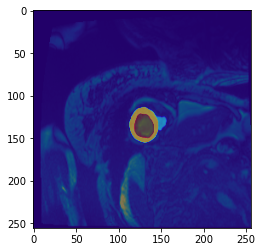

In [10]:
c, mask, img, mean, std  = val_dataset[70]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0]
probas = torch.nn.functional.softmax(pred, dim=0)
pmask = torch.zeros_like(mask)
pmask[0] = probas[1] * 1 + probas[2] * 2 + probas[3] * 3
print(1 - dice_loss(mask.unsqueeze(0).long(), pred.unsqueeze(0)).item())
plt.imshow(img.numpy()[0])
plt.imshow(pmask.cpu().numpy()[0], alpha=0.5, cmap=plt.cm.jet)
plt.show()

In [11]:
torch.cuda.empty_cache()